### Imports

In [8]:
import numpy as np
from matplotlib.pyplot import get_cmap
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
from boston_ds import BostonDS
from drift_detection.drift_testers.ks_drift_tester import KsDriftTester
from helpers.data_helper import sample_from_data
from helpers.model_helper import XgbModel
from helpers.utils import calc_perf_kpis

from drift_detection.drift_detector import DriftDetector


### Prepare Boston data for demo

In [17]:

# ============================================================= Initial data setup
# Load and prep boston data
boston = BostonDS()

x = boston.x
y = boston.y
x_cont_features = boston.cont_features
x_int_features = boston.int_features
x_cat_features = boston.cat_features

# from entire dataset, choose subset for initial train/test
TRAIN_TEST_SIZE = 520
x_sample, y_sample = sample_from_data(x, y, TRAIN_TEST_SIZE)
x_train, x_test, y_train, y_test = train_test_split(x_sample, y_sample, test_size=0.4, random_state=10)

display(x_train.head())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
954,9.381999,0.0,18.1,0,0.713544,6.185,98.214336,2.289557,24,666,20.2,396.9,18.13
2031,0.287416,12.5,7.87,0,0.523623,6.172,96.359651,5.96562,5,311,15.2,396.9,19.15
2246,0.615921,0.0,6.2,1,0.507325,6.879,77.006739,3.279534,8,307,17.4,390.39,9.93
2390,3.650728,0.0,18.1,0,0.71544,4.963,91.393096,1.774197,24,666,20.2,316.03,14.0
943,15.199911,0.0,18.1,0,0.741049,6.152,100.151069,1.931354,24,666,20.2,9.32,26.45


### Initial model train

In [10]:

# ============================================================= Train step

# Build model on train data
model = XgbModel()
model.fit(x_train, y_train)


### Drift detector configuration and train

Create a drift detector and auto-select and fit drift testers based on feature types:
* Numeric features - Kolmogorov–Smirnov tester
* Categorical tests - Chi^2 tester
* All together - KL Divergence (Multivariable) tester

All testers default with pval=0.005, with three conseq. failures.

In Advanced mode - user can select other testers, p-vals, conseq failures.\n
Available testers:
* Kolmogorov–Smirnov
* Chi^2
* Multivariate KL Divergence with autofit
* Multivariate MMD (Max Mean Divergence) with autofit
* Multivatiate KS over PCA


In [11]:
# Create Feature drift detector with all default testers
drift_detector = DriftDetector()
drift_detector.autoselect_testers(x_cont_features, x_int_features, x_cat_features)
drift_detector.fit(x_train)


### Collect data for plots later

In [12]:
# Initial predction / drift test plan
y_pred = model.predict(x_test)
drift_test_results = drift_detector.test_drift(x_test)

In [13]:
# Calc and store initial model performance KPIs on test
kpi = calc_perf_kpis(x_test, y_test, y_pred)
kpi['drift_detected'] = drift_test_results['drift_detected']
kpi['test_exceptions'] = drift_test_results['test_exceptions']

perf_kpis = pd.DataFrame(columns=kpi.keys()).append(kpi, ignore_index=True)

### Runtime step

In [14]:
# ============================================================= Runtime step
number_of_batches = 300
start_drift_at_batch = 100
sample_size = 50


# Runtime loop
for i in range(number_of_batches):
    # Sample batch from data (No drift yet)
    x_sample, y_sample = sample_from_data(x, y, sample_size)

    # modify data batch to create feature drift
    if i > start_drift_at_batch:
        x_sample['RM'] = x_sample['RM'] + x['RM'].std() * 0.01 * (i - start_drift_at_batch)
        x_sample['LSTAT'] = x_sample['LSTAT'] + x['LSTAT'].std() * 0.01 * (i - start_drift_at_batch)

    # predict
    y_pred = model.predict(x_sample)

    # calc RMSE (For demo only, cannot do in real runtime - no labels there
    kpi_sample = calc_perf_kpis(x_sample, y_sample, y_pred)

    # Execute drift test
    drift_test_results = drift_detector.test_drift(x_sample)

    kpi_sample['drift_detected'] = drift_test_results['drift_detected']
    kpi_sample['test_exceptions'] = drift_test_results['test_exceptions']
    perf_kpis = perf_kpis.append(kpi_sample, ignore_index=True)


### Plot RMSE and detection results

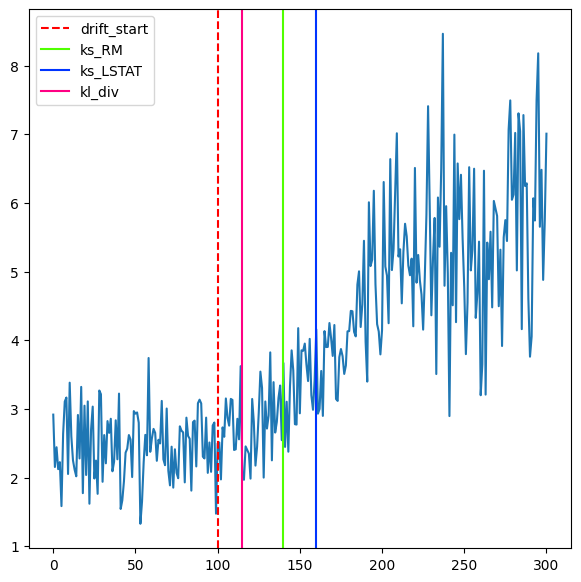

,R_sq,ajd_R_sq,MAE,MSE,RMSE,drift_detected,test_exceptions
0,0.914554,0.908828,1.733352,1.733352,2.916569,False,[]
1,0.950654,0.932835,1.224627,1.224627,2.153970,False,[]
2,0.917637,0.887895,1.369260,1.369260,2.441528,False,[]
3,0.933876,0.909998,1.193679,1.193679,2.122538,False,[]
4,0.948716,0.930197,1.345284,1.345284,2.224367,False,[]
...,...,...,...,...,...,...,...
296,0.697855,0.588747,3.711971,3.711971,5.652115,True,"[ks_RM, ks_LSTAT, kl_div]"
297,0.456411,0.260115,4.066637,4.066637,6.481644,True,"[ks_RM, ks_LSTAT, kl_div]"
298,0.668218,0.548409,3.406231,3.406231,4.878434,True,"[ks_RM, ks_LSTAT, kl_div]"
299,0.589631,0.441443,3.928937,3.928937,5.749896,True,"[ks_RM, ks_LSTAT, kl_div]"


In [15]:

# ========================================================================== Plot

fig, axs = plt.subplots(figsize=(7, 7))

# plot RMSE (Loss function) line
axs.plot(perf_kpis['RMSE'])

# plot vertical lin for data drift start point
axs.axvline(x=start_drift_at_batch, label='drift_start', color='r', linestyle='dashed')

# Get drift detector x_history for plots
x_history = drift_detector.history_df

# plot vertical line for each tester that fired
fail_detections = []
cmap = get_cmap('hsv', 15)

for i, test_name in enumerate(drift_detector.get_test_names()):
    if x_history[test_name].sum() > 0:
        detection_time = np.where(x_history[test_name] == True)[0].min()
        axs.axvline(x=detection_time, label=test_name, color=cmap(i))

# Display plot
axs.legend()
plt.show()

display(perf_kpis)
